In [57]:
pip install mysql-connector-python

Note: you may need to restart the kernel to use updated packages.


In [76]:
import mysql.connector
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import seaborn as sns
import datetime
import numpy as np
import random

sns.set()

# Establish Conncetion

In [77]:
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="Zoobnoob1",
  database="pharma"
)

# Utility Functions

## Place order

In [78]:
def askwhatOrder():
    chemList = []
    isAvailable = 1
    keepAsking = True
    drugPrice ={}
    drugNameID = {}
    drug = ''
    quantity = ''
    totalVal = 0
    eachTotal = 0
    drugsList = []
    eachDrugPrice = {}
    
    digitquery = """SELECT ID
    FROM Orders
    ORDER BY ID desc
    LIMIT 1"""
    mydb = mysql.connector.connect(
                      host="localhost",
                      user="root",
                      password="Zoobnoob1",
                      database="pharma"
                    )
    mycursor = mydb.cursor()
    mycursor.execute(digitquery)
    myresult = mycursor.fetchall()
    mycursor.close()
    for x in myresult:
        digitStr = int(x[0][3:]) + 1

    path = input("What orders do you want to place today? Type B for Distributor. Type V for Vendor order placement")
    print("\n")
    
    if (path == 'B'):
        
        userId = input('Enter the distributor ID: ')
       
        mycursor = mydb.cursor()
        mycursor.execute("SELECT * FROM Drugs")
        myresult = mycursor.fetchall()
        mycursor.close() 
        
        while (keepAsking):
            print("\nPlease select the drug you want: ")
            for x in myresult:
                drugPrice[x[1]] = x[6]
                drugNameID[x[1]] = x[0]
                print(x[1])
            drug = input("\nEnter the drug you want to order: ")
            quantity = input("\nEnter the quantity you want: ")
            
            mycursor = mydb.cursor()
            mycursor.callproc("get_drug_stock",(drug,quantity))

            for result in mycursor.stored_results():
                res = result.fetchall()
                stock = int(res[0][0])

            mycursor.close() 

            if(stock >= int(quantity)):
                eachTotal = drugPrice[drug] * int(quantity)
                totalVal = totalVal + eachTotal
                drugsList.append(drug)
                eachDrugPrice[drug] = (eachTotal,quantity)

                decision = input("\nDo you want to buy more drugs? type Yes to continue and No to stop").lower()
                keepAsking = True if decision == 'yes' else False
            else:
                print("The drug you want to order is not available or is less in quantity")
        
        random_month = random.randint(1,12)
        random_date = random.randint(1,28)
            
        mycursor = mydb.cursor()
        mycursor.callproc("create_order",(("OD0"+str(digitStr)),datetime.date(2020, random_month, random_date), float(totalVal), userId,))
        
        mydb.commit()
        
        for drg in drugsList:
        
            mycursor.callproc("push_drugs_in_order",(("OD0"+str(digitStr)),drugNameID[drg], eachDrugPrice[drg][1], float(eachDrugPrice[drg][0]),))
            mydb.commit()
            
    elif (path == 'V'):
        while(keepAsking):
            mycursor = mydb.cursor()
            mycursor.execute("SELECT * FROM Chemicals")
            myresult = mycursor.fetchall()
            mycursor.close()

            chemIDName = {}

            print("\nPlease select the chemical you want: ")
            for x in myresult:
                chemIDName[x[0]] = x[1]
                print(x[0],":",x[1])
                
            chem = input("\nEnter the ID of the chemical you want to order: ")

            VendorIDPrice = {}

            query = """SELECT vi.Vendor_ID, v.Name, vi.Price_per_packet 
            FROM Vendor_Inventory AS vi
            JOIN Vendor as v
            ON vi.Vendor_ID = v.Vendor_ID
            WHERE vi.Chemical_ID = \"{}\"""".format(chem)

            mycursor = mydb.cursor()
            mycursor.execute(query)
            myresult = mycursor.fetchall()
            mycursor.close()

            print("\nThe following vendors offer {}".format(chemIDName[chem]))
            for x in myresult:
                print(x[0],x[1],"${} per packet".format(x[2]))
                VendorIDPrice[x[0]] = x[2]

            vendorID = input("\nEnter the ID of the vendor you want to place the order from: ")
            quantity = input("\nEnter the quantity (in 1k packets): ")

            totalVal = VendorIDPrice[vendorID] * int(quantity)

            args = (chem,float(quantity),float(totalVal))
            chemList.append(args)

            cont = input("\nBuy more chemicals?(Yes/No):")
            if cont == "Yes":
                keepAsking = True
            else:
                keepAsking = False

        totalOrderVal = 0
        for c in chemList:
            totalOrderVal += c[2]
            
        random_month = random.randint(1,12)
        random_date = random.randint(1,28)

        mycursor = mydb.cursor()
        mycursor.callproc("create_order",(("OD0"+str(digitStr)),datetime.date(2020, random_month, random_date), float(totalOrderVal), vendorID,))
        mydb.commit()
        
        for c in chemList:
            mycursor.callproc("push_chemicals_in_order",(("OD0"+str(digitStr)),c[0],c[1],c[2]))
            mydb.commit()

In [79]:
askwhatOrder()

What orders do you want to place today? Type B for Distributor. Type V for Vendor order placementB


Enter the distributor ID: B001

Please select the drug you want: 
omeprazole
Aspirin
cimetidine
Acetaminophen
lansoprazole
Fluticasone
bisacodyl
Pseudoephedrine
Pepto Bismol
Loratadine
Dramamine
Prednisone
triamcinolone

Enter the drug you want to order: Dramamine

Enter the quantity you want: 2
The drug you want to order is not available or is less in quantity

Please select the drug you want: 
omeprazole
Aspirin
cimetidine
Acetaminophen
lansoprazole
Fluticasone
bisacodyl
Pseudoephedrine
Pepto Bismol
Loratadine
Dramamine
Prednisone
triamcinolone

Enter the drug you want to order: Aspirin

Enter the quantity you want: 2
The drug you want to order is not available or is less in quantity

Please select the drug you want: 
omeprazole
Aspirin
cimetidine
Acetaminophen
lansoprazole
Fluticasone
bisacodyl
Pseudoephedrine
Pepto Bismol
Loratadine
Dramamine
Prednisone
triamcinolone

Enter the drug

# Get best vendor

In [82]:
def getBestOption():
    mycursor = mydb.cursor()
    mycursor.execute("SELECT * FROM Chemicals")
    myresult = mycursor.fetchall()
    mycursor.close()

    chemIDName = {}
    print("Please select the chemical you want: ")
    for x in myresult:
        chemIDName[x[0]] = x[1]
        print(x[0],":",x[1])
    print("\n")
    chem = input("Enter the chemical you want to place an order for: ")
    print(chem)
    x = 2
    sortBy = input("Enter C for the cheapest option or F for the fastest delivery: ").lower()
    
    sqlQuery = "select get_cheapest_vendor(%s)"
    mycursor = mydb.cursor()
    
    if(sortBy == 'c'):
        sqlQuery     = "select get_cheapest_vendor(%s)"
        mycursor.execute(sqlQuery,(chem,))
        myResults = mycursor.fetchall()
        for result in myResults:
            print(result[0]+ " is the cheapest vendor for this chemical.")
        
    elif(sortBy == 'f'):
        sqlQuery     = "select get_fastest_vendor(%s)"
        mycursor.execute(sqlQuery,(chem,))
        myResults = mycursor.fetchall()
        for result in myResults:
            print(result[0]+ " is the fastest vendor for this chemical.")


In [83]:
getBestOption()

Please select the chemical you want: 
C001 : acetylsalicylic acid
C002 : hypromellose
C003 : mannitol
C004 : N-(4-hydroxyphenyl)acetamide
C005 : povidone
C006 : benzimidazole
C007 : titanium dioxide
C008 : magnesium carbonate
C009 : polyethylene glycol
C010 : hydroxypropyl cellulose
C011 : fluticasone propylate
C012 : magnesium stearate
C013 : Pseudoephedrine hydrochloride
C014 : Loratadine
C015 : bismuth subsalicylate
C016 : silicon dioxide
C017 : prednisolone
C018 : dimenhydrinate
C019 : lactose
C020 : Glycerin
C021 : Isopropyl Palmitate


Enter the chemical you want to place an order for: hypromellose
hypromellose
Enter C for the cheapest option or F for the fastest delivery: C
V012 is the cheapest vendor for this chemical.


# View Approvals

In [84]:
mycursor = mydb.cursor()
mycursor.execute("SELECT * FROM approvals_for_board;")
myresult = mycursor.fetchall()
drugNameList = []
approvedList = []
for result in myresult:
    drugNameList.append(result[1])
    approvedList.append(result[2])
data = {'Name' : drugNameList, 'Lab Approved' : approvedList}
drugLabResults = pd.DataFrame(data)

In [85]:
drugLabResults

,Name,Lab Approved
0,omeprazole,Yes
1,cimetidine,Pending
2,lansoprazole,Yes
3,Fluticasone,Yes
4,bisacodyl,Yes
5,Pepto Bismol,Yes
6,Dramamine,Yes
7,triamcinolone,Pending


# View top drug sales

In [86]:
mycursor = mydb.cursor()
mycursor.execute("SELECT * FROM top_drug_sales;")
myresult = mycursor.fetchall()
drugNameList = []
PriceList = []
for result in myresult:
    drugNameList.append(result[0])
    PriceList.append(result[1])
data = {'Name' : drugNameList, 'Order_Price' : PriceList}
topdrugOrders = pd.DataFrame(data)

In [87]:
topdrugOrders

,Name,Order_Price
0,D001,omeprazole
1,D002,Aspirin
2,D003,cimetidine
3,D004,Acetaminophen
4,D005,lansoprazole


# View ingredients of a drug

In [88]:
drugName = input("Enter the drug name:")

mycursor = mydb.cursor()
callproc = "CALL get_chemicals_in_drug(\"{}\")".format(drugName)
mycursor.execute(callproc)
myresult = mycursor.fetchall()
mycursor.close()

chemId = []
chemName = []
chemStock = []
chemRatio = []

for result in myresult:
    chemId.append(result[0])
    chemName.append(result[1])
    chemStock.append(result[2])
    chemRatio.append(result[3])
    
data = {"Chemical ID":chemId, "Name":chemName, "Current Stock(in 1k packets)":chemStock, "Mix in Parts":chemRatio}
drugIngredients = pd.DataFrame(data)

Enter the drug name:


In [ ]:
drugIngredients

# Analytics

## Find profit for custom date range

In [60]:
def find_profits():
    print("Enter the dates between which you would like to see the profits")
    start = input("Starting date:")
    end = input("Ending data:")
    
    query = "SELECT get_profits(%s,%s)"
    placeholder = (start,end)
    
    mycursor = mydb.cursor()
    mycursor.execute(query,placeholder)
    myresult = mycursor.fetchall()
    mycursor.close()
    
    for x in myresult:
        print("${}k".format(x[0]))

In [61]:
find_profits()

Enter the dates between which you would like to see the profits
Starting date:2020-01-01
Ending data:2020-01-30
$-1k


## Monthly Profit over 2020

In [62]:
def get_profit_by_month():
    profits = []
    months = list(range(1,13))
    for i in range(len(months)):
        if months[i] > 9:
            s = "2020-{}-01".format(months[i])
            if months[i] == 12:
                e = "2021-01-01"
            else:
                e = "2020-{}-01".format(months[i+1])
        else:
            s = "2020-0{}-01".format(months[i])
            if months[i] == 9:
                e = "2020-10-01"
            else:
                e = "2020-0{}-01".format(months[i+1])
                
        query = "SELECT get_profits(%s,%s)"
        dates = (s,e)
        
        mycursor = mydb.cursor()
        mycursor.execute(query,dates)
        myresult = mycursor.fetchall()
        mycursor.close()
        
        for x in myresult:
            profits.append(x[0])

    return profits

In [63]:
def print_profits_by_month():
    profits = get_profit_by_month()
    profits_dict = {}
    months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
    for m,i in zip(months,profits):
        profits_dict[m] = i
        
    return profits_dict

In [64]:
profit_dict = print_profits_by_month()

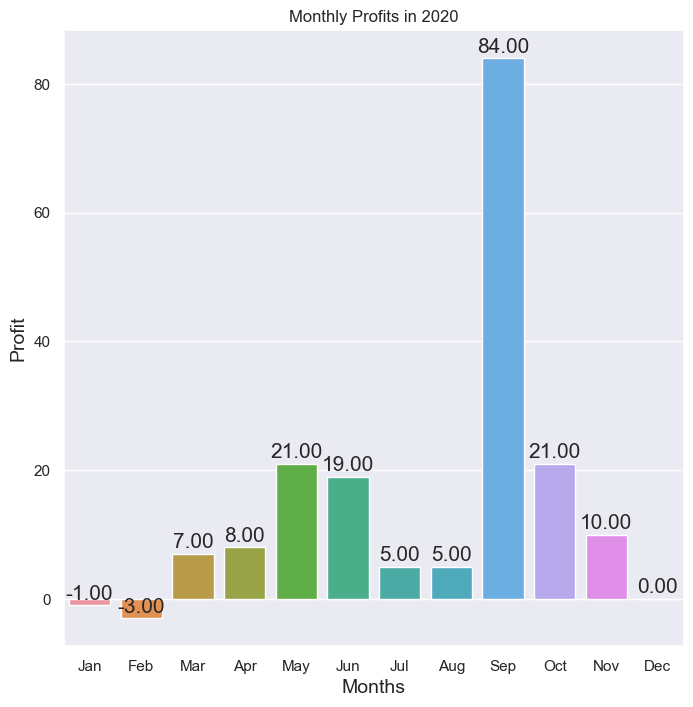

In [65]:
plt.figure(figsize=(8, 8))

plots = sns.barplot(x=list(profit_dict.keys()), y=list(profit_dict.values()))

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'), 
                    (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                size=15, xytext=(0, 8),
                textcoords='offset points')

plt.xlabel("Months", size=14)
plt.ylabel("Profit", size=14)
plt.title("Monthly Profits in 2020")

plt.show()

## Contribution of each drug to total sales

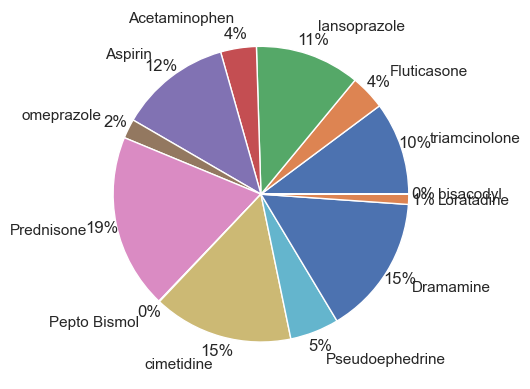

In [66]:
drugNameList = []
salesValue = []

mycursor = mydb.cursor()
mycursor.execute("SELECT d.Name,SUM(Total_Price) FROM Drugs_in_Orders as dio JOIN Drugs as d ON d.ID = dio.Drugs_ID GROUP BY Drugs_ID;")
myresult = mycursor.fetchall()
mycursor.close()

for result in myresult:
    drugNameList.append(result[0])
    salesValue.append(result[1])

plt.pie(salesValue, labels = drugNameList,autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)
plt.show()

## Difference between listed delivery time and actual delivery time

In [67]:
query = """SELECT v.Vendor_ID, v.Average_Shipping_Time_in_days, s.ETA_in_days
FROM Orders as o
JOIN Vendor as v
ON o.Recipient_ID = v.Vendor_ID
JOIN Ships as s
ON o.ID = s.Order_ID
WHERE Recipient_ID LIKE \"V%\";"""

mycursor = mydb.cursor()
mycursor.execute(query)
myresult = mycursor.fetchall()
mycursor.close()

vendor = []
averageTime = []
eta = []

for result in myresult:
    vendor.append(result[0])
    averageTime.append(int(result[1]))
    eta.append(int(result[2]))
    
data = {"Vendor":vendor, "Average Delivery Time (in days)": averageTime, "Actual ETA (in days)": eta}
deliverydifference = pd.DataFrame(data)

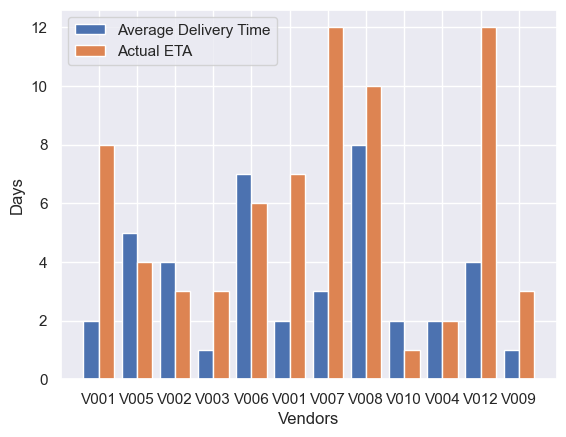

In [68]:
x = np.arange(len(vendor))
plt.bar(x-0.2, averageTime, 0.4) 
plt.bar(x+0.2, eta, 0.4) 
plt.xticks(x,vendor)
plt.xlabel("Vendors")
plt.ylabel("Days")
plt.legend(["Average Delivery Time","Actual ETA"])
plt.show()